In [29]:
import pydpmd as dp
import numpy as np
import os
import matplotlib.pyplot as plt

def get_relaxation_time(f, t):
    tau = np.interp(1 / np.e, f[::-1], t[::-1])
    if not np.min(f) < 1 / np.e:
        return np.nan
    return tau

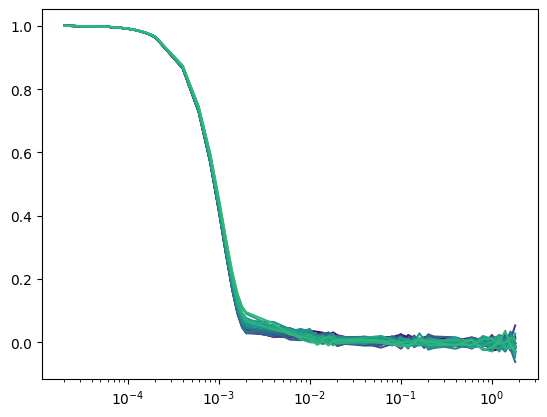

In [40]:
root = '/home/mmccraw/dev/data/10-02-25/disk-shear-modulus-small/trial-0/'
dt = 2e-2
T = 1e-6
i = 0
phi_norm = plt.Normalize(vmin=0.8, vmax=0.85)
cmap = plt.cm.viridis
G0, tau, phi = [], [], []
while os.path.exists(shear_modulus_path := os.path.join(root, f'shear_modulus_{i}.npz')):
    i += 1
    shear_modulus = np.load(shear_modulus_path)
    G = np.mean(shear_modulus['shear_modulus'], axis=1)
    t = shear_modulus['t'] * dt * np.sqrt(T)
    phi.append(np.mean(shear_modulus['packing_fraction']))
    G0.append(G[0])
    tau.append(get_relaxation_time(G / G[0], t))

    plt.plot(t, G / G[0], c=cmap(phi_norm(phi[-1])))
plt.xscale('log')
# plt.yscale('log')

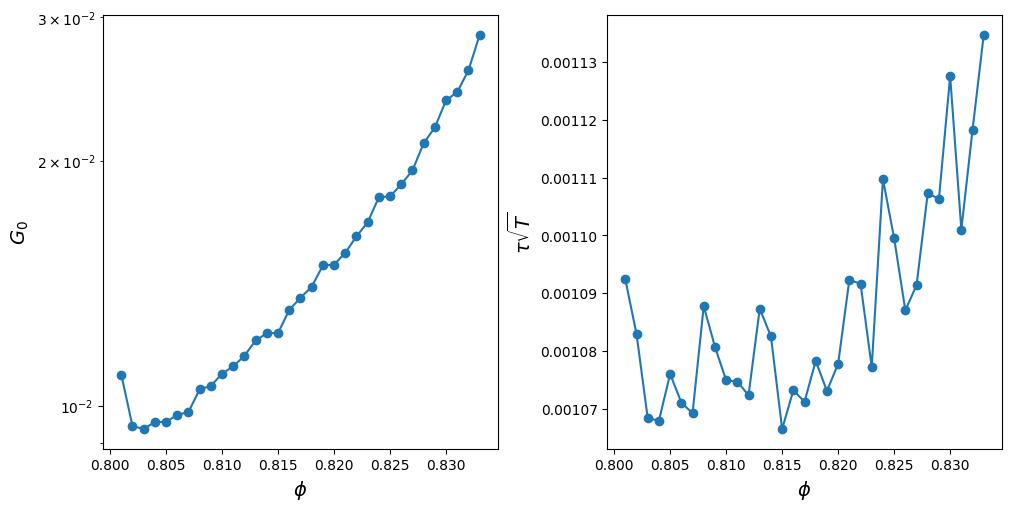

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True, sharex=True)
ax[0].plot(phi, G0, marker='o')
ax[1].plot(phi, tau, marker='o')
ax[0].set_yscale('log')
ax[0].set_ylabel(r'$G_0$', fontsize=14)
ax[1].set_ylabel(r'$\tau \sqrt{T}$', fontsize=14)
for a in ax:
    a.set_xlabel(r'$\phi$', fontsize=14)
plt.show()
